In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,GlobalAveragePooling2D,Input,Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [3]:
class_names = ["cloudy","desert","green_area","water"]

In [4]:
dataset =tf.keras.utils.image_dataset_from_directory(
    './data',
    labels='inferred',
    label_mode='categorical',
    class_names= class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 5631 files belonging to 4 classes.


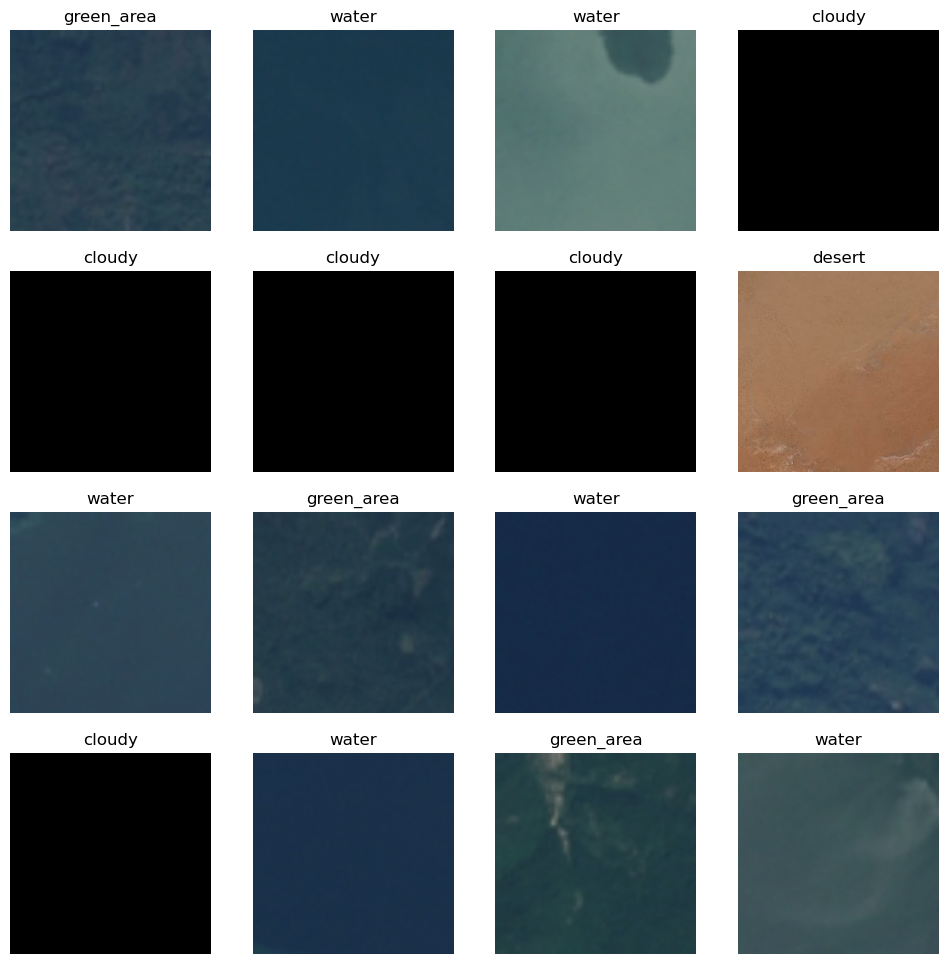

In [5]:
plt.figure(figsize = (12,12))

for images, labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")

In [6]:
train_size = 0.80
val_size = 0.20

In [7]:
total_count = len(dataset)

train_count = int(total_count * train_size)
val_count = int(total_count * val_size)

print("total batch:", total_count)
print("train batch:", train_count)
print("validation batch:", val_count)

total batch: 176
train batch: 140
validation batch: 35


In [8]:
train = dataset.take(train_count)
#remaining = dataset.skip(train_count)
val = dataset.skip(train_count).take(val_count)
test = dataset.skip(train_count + val_count)

In [9]:
#metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

####  CNN

In [10]:
def build_cnn(input_shape, num_classes):
    print("CNN \n")
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),  # First convolutional layer
        MaxPooling2D((2, 2)),  # Max pooling layer
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),  # Flatten before dense layers
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Output layer (for regression)
    ])
    print(model.summary())
    return model

#### ResNet50

In [11]:
def build_resnet50(input_shape, num_classes):
    print("ResNet \n")
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        Input(shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        
        Dense(1024, activation='relu'),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        
        Dense(num_classes, activation = 'softmax')
    ])
    print(model.summary())
    return model

#### GoogLeNet 

In [12]:
def build_googlenet(input_shape, num_classes):
    print("GoogLeNet")
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        Flatten(),
        
        Dense(128,activation='relu'),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        
        Dense(num_classes, activation='softmax')
    ])
    print(model.summary())
    return model

#### VGG 16 

In [13]:
def build_VGG16(input_shape, num_classes):
    print("VGG16")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        Input(shape=input_shape),
        base_model,
        GlobalAveragePooling2D(),
        
        Dense(1024, activation='relu'),
        BatchNormalization(),
        
        Dense(128, activation='relu'),
        
        Dense(num_classes, activation = 'softmax')
    ])
    print(model.summary())
    return model

#### AlexNet

In [14]:
def build_alexnet(input_shape, num_classes):
    print("AlexNet")
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    print(model.summary())
    return model

In [15]:
input_shape = (256, 256, 3)
num_classes = len(class_names)

In [16]:
models = {
    'CNN': build_cnn(input_shape, num_classes),
    'AlexNet': build_alexnet(input_shape, num_classes),
    'ResNet50': build_resnet50(input_shape, num_classes),
    'GoogLeNet': build_googlenet(input_shape, num_classes),
    'VGG16':build_VGG16(input_shape, num_classes)
}

CNN 



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,510,084 (120.20 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

None
AlexNet


C:\Users\Kawish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,297,732 (222.39 MB)

 Trainable params: 58,297,732 (222.39 MB)

 Non-trainable params: 0 (0.00 B)

None
ResNet 



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,821,700 (98.50 MB)

 Trainable params: 25,766,532 (98.29 MB)

 Non-trainable params: 55,168 (215.50 KB)

None
GoogLeNet


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ ?                           │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None
VGG16


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,375,812 (58.65 MB)

 Trainable params: 15,373,764 (58.65 MB)

 Non-trainable params: 2,048 (8.00 KB)

None


In [17]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
histories = {}

for name, model in models.items():
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f" \n Training {name}...")
    histories[name] = model.fit(
        train,
        validation_data=val,
        epochs=10,
        #callbacks=[early_stopping]
    )

 
 Training CNN...
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 97s 683ms/step - accuracy: 0.6753 - loss: 225.4505 - val_accuracy: 0.4652 - val_loss: 0.7868
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 95s 681ms/step - accuracy: 0.8387 - loss: 1.2540 - val_accuracy: 0.5214 - val_loss: 1.0410
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 666ms/step - accuracy: 0.8652 - loss: 0.2781 - val_accuracy: 0.5214 - val_loss: 1.0397
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 663ms/step - accuracy: 0.8918 - loss: 0.2545 - val_accuracy: 0.5277 - val_loss: 1.0224
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 664ms/step - accuracy: 0.8926 - loss: 0.2359 - val_accuracy: 0.5259 - val_loss: 1.0030
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 665ms/step - accuracy: 0.8913 - loss: 0.2513 - val_accuracy: 0.5259 - val_loss: 0.9902
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 667ms/step - accuracy: 0.8963 - loss: 0.2378 - val_accuracy: 0.5286 - val_loss: 0.9880
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 93s 662ms/step - accur

140/140 ━━━━━━━━━━━━━━━━━━━━ 2431s 17s/step - accuracy: 0.8682 - loss: 0.2842 - val_accuracy: 0.8134 - val_loss: 0.4821


In [19]:
BOLD = "\033[1m"
FONT_SIZE_INCREASE = "\033[2J"

In [20]:
# Function to plot ROC curve
def plot_roc(model, test_ds, class_names):
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [21]:
# Function to plot confusion matrix
def plot_confusion_matrix(model, test_ds, class_names):
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

Evaluating CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


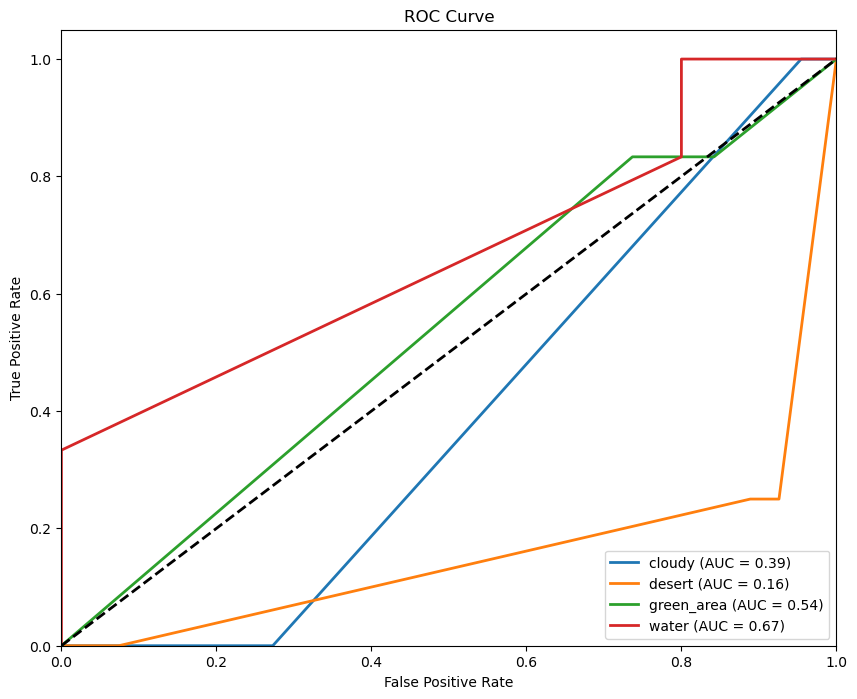

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


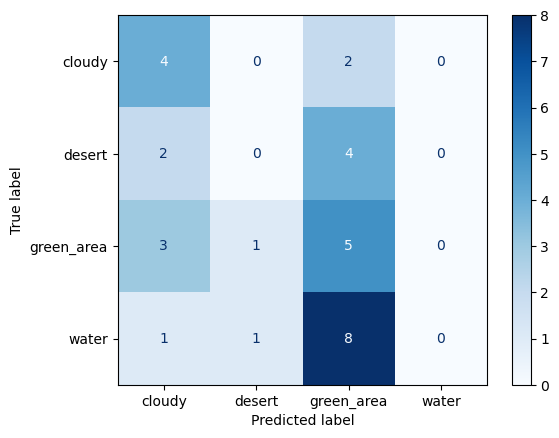

Evaluating AlexNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


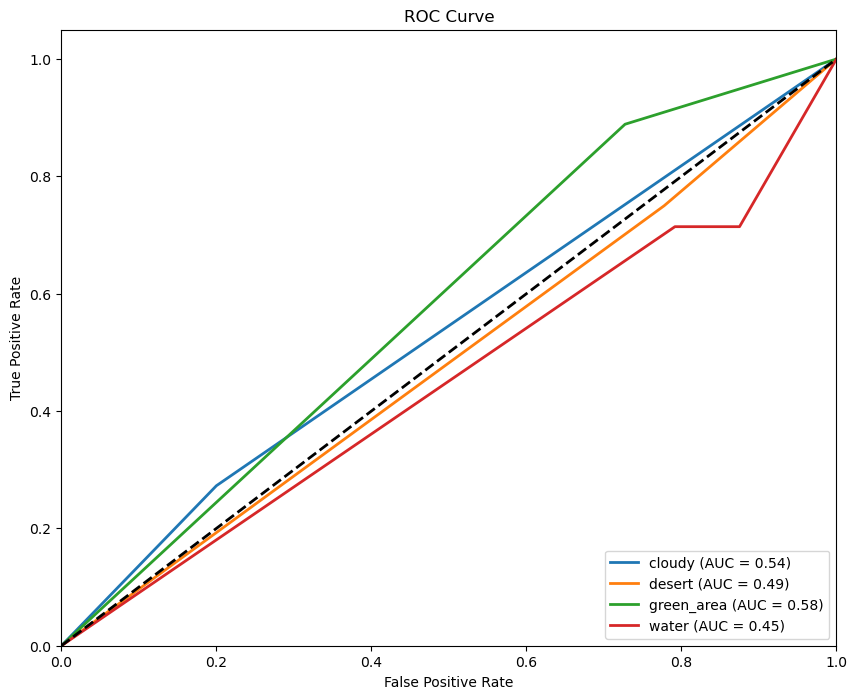

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


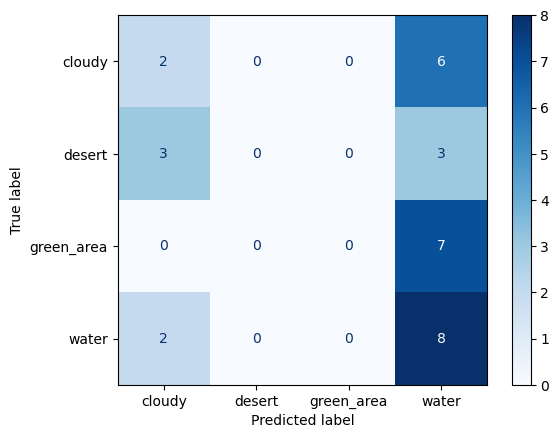

Evaluating ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


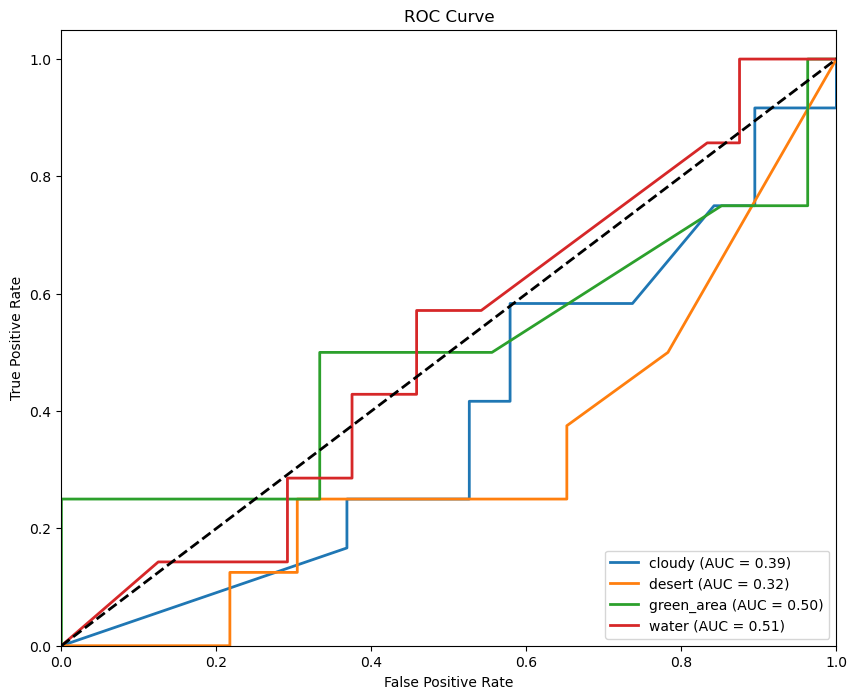

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


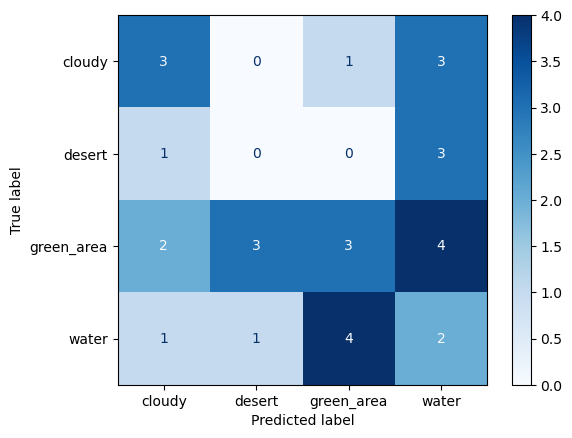

Evaluating GoogLeNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


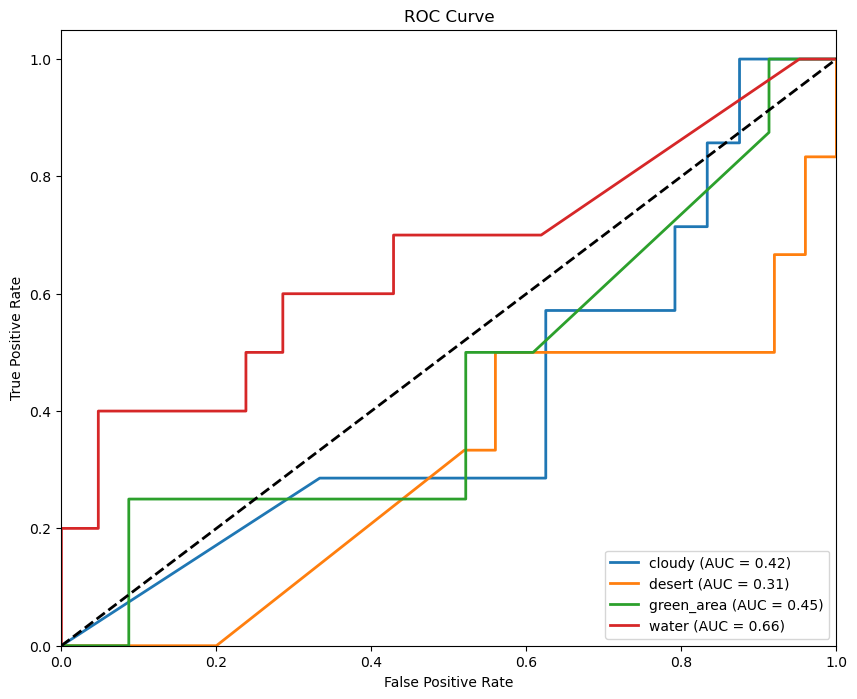

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


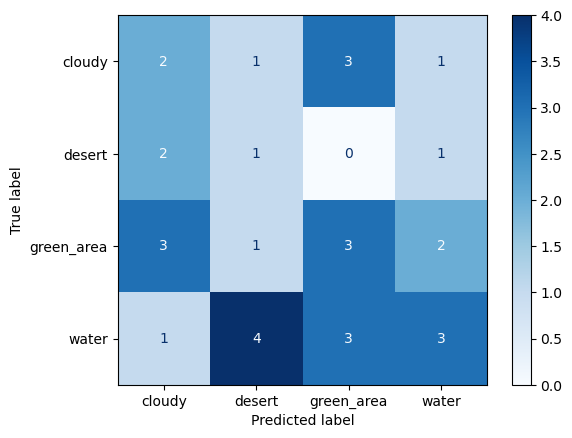

Evaluating VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


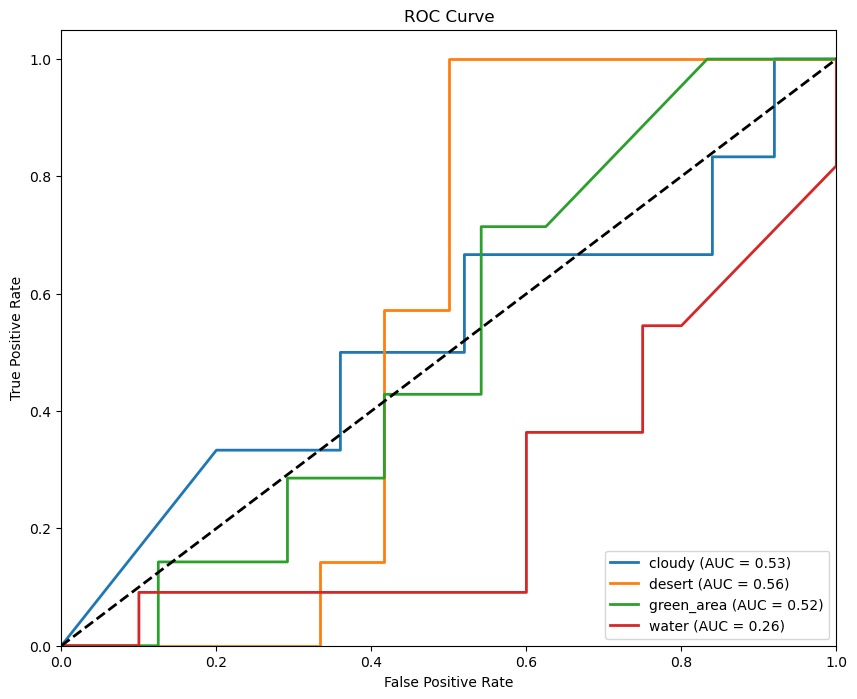

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


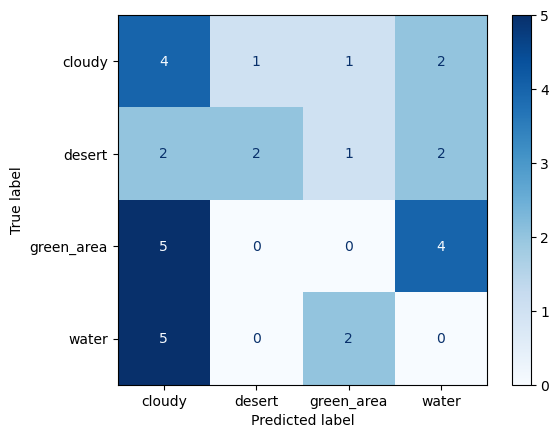

In [22]:
# Plot ROC curve and confusion matrix for each model
for name, model in models.items():
    print(f"{FONT_SIZE_INCREASE}{BOLD}Evaluating {name}...")
    plot_roc(model, test, class_names)
    plot_confusion_matrix(model, test, class_names)